In [ ]:
# !git clone https://github.com/Byaidu/PDFMathTranslate.git
repo_url = 'PDFMathTranslate'

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from pydriller import Repository
import pandas as pd
import torch
import gc
import os
from collections import Counter, defaultdict

# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("mamiksik/CommitPredictorT5")
model = AutoModelForSeq2SeqLM.from_pretrained("mamiksik/CommitPredictorT5").to(device)
model.eval()

MAX_INPUT_TOKENS = 512
MAX_OUTPUT_TOKENS = 128


def safe_infer(diff_text):
    if not diff_text:
        return ""
 
    inputs = tokenizer(
        diff_text,
        return_tensors='pt',
        max_length=MAX_INPUT_TOKENS,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=MAX_OUTPUT_TOKENS)

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


## Part B - Report and compute the baseline repo stats

In [ ]:

def total_commits(repo_url):
    return sum(1 for _ in Repository(repo_url).traverse_commits())

def total_files(repo_url):
    files = set()
    for commit in Repository(repo_url).traverse_commits():
        for m in commit.modified_files:
            if m.new_path:
                files.add(m.new_path)
            elif m.old_path:
                files.add(m.old_path)
    return len(files)

def avg_mod_files_per_commit(repo_url):
    total_files, total_commits = 0, 0
    for commit in Repository(repo_url).traverse_commits():
        total_commits += 1
        total_files += len(commit.modified_files)
    return total_files / total_commits if total_commits else 0

def distribution_fix_type_llm(repo_url):
    fix_counter = Counter()

    for commit in Repository(repo_url).traverse_commits():
        for mf in commit.modified_files:
            if mf.diff:
                prediction = safe_infer(mf.diff)
                if prediction:
                    fix_counter[prediction] += 1

    return dict(fix_counter)

def most_modified_extension(repo_url):

    ext_counter = Counter()
    for commit in Repository(repo_url).traverse_commits():
        for mf in commit.modified_files:
            path = mf.new_path or mf.old_path
            if path and "." in path:
                ext = os.path.splitext(path)[-1]
                ext_counter[ext] += 1
    return ext_counter.most_common(1)[0] if ext_counter else None


In [ ]:
import json
import csv
import pandas as pd

def analyze_repo(repo_url, out_file="repo_stats.json", out_format="json"):
    results = {}

    results["total_commits"] = total_commits(repo_url)
    results["total_files"] = total_files(repo_url)
    results["avg_modified_files_per_commit"] = avg_mod_files_per_commit(repo_url)
    results["fix_type_distribution"] = distribution_fix_type_llm(repo_url)
    results["most_modified_extension"] = most_modified_extension(repo_url)

    
    print("\n---- Repository Analysis ----")
    for k, v in results.items():
        print(f"{k}: {v}")
    
    # Save results

    df=pd.DataFrame([results])
    df.to_csv(out_file, index=False)
    

    print(f"\nResults saved to {out_file}")
    return results

analyze_repo(repo_url, out_file="b.csv")



=== Repository Analysis ===
total_commits: 1067
total_files: 129
avg_modified_files_per_commit: 1.5398313027179007
fix_type_distribution: {'add missing comments to the missing blocklist': 1, 'add missing test for': 2, 'add missing comment': 14, 'add version number in pdf2zh.six.py': 1, 'add support for saslprep with unicode data': 1, 'add encryption and decryption code to arcfour.py': 1, 'add comments to ascii85/asciihexdecode': 2, 'add cache_dir/cache_dir.py': 1, 'add missing type annotations': 1, 'add missing code in the bitparser class': 1, 'add support for unicode and code-points in cmap': 1, 'add missing missing imports': 7, 'add documentation for number tree': 1, 'add support for unicode numbers in key list': 1, 'convert font metrics from adobe core 14 to 4': 1, 'add missing comments to a missing sequence': 1, 'add support for multilevel and multilevel text format': 1, 'add missing support for jpg support in bmp': 1, 'add missing features in the standard encoding tables': 1, 'ad

{'total_commits': 1067,
 'total_files': 129,
 'avg_modified_files_per_commit': 1.5398313027179007,
 'fix_type_distribution': {'add missing comments to the missing blocklist': 1,
  'add missing test for': 2,
  'add missing comment': 14,
  'add version number in pdf2zh.six.py': 1,
  'add support for saslprep with unicode data': 1,
  'add encryption and decryption code to arcfour.py': 1,
  'add comments to ascii85/asciihexdecode': 2,
  'add cache_dir/cache_dir.py': 1,
  'add missing type annotations': 1,
  'add missing code in the bitparser class': 1,
  'add support for unicode and code-points in cmap': 1,
  'add missing missing imports': 7,
  'add documentation for number tree': 1,
  'add support for unicode numbers in key list': 1,
  'convert font metrics from adobe core 14 to 4': 1,
  'add missing comments to a missing sequence': 1,
  'add support for multilevel and multilevel text format': 1,
  'add missing support for jpg support in bmp': 1,
  'add missing features in the standard en

## Part c - d - e - f
Result stored in "radon_similarity.csv"

In [ ]:
import json
from pydriller import Repository
from radon.complexity import cc_visit
from radon.metrics import mi_visit
from radon.raw import analyze
from transformers import AutoTokenizer, AutoModel
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")

def get_codebert_embedding(code):
    if code is None or code.strip() == "":
        return None
    inputs = tokenizer(code, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return emb

def semantic_similarity(code1, code2):
    e1 = get_codebert_embedding(code1)
    e2 = get_codebert_embedding(code2)
    if e1 is None or e2 is None:
        return None
    # cosine similarity
    sim = float(torch.nn.functional.cosine_similarity(
        torch.tensor(e1), torch.tensor(e2), dim=0
    ).item())
    return sim

def token_similarity_bleu(code1, code2):
    if code1 is None or code2 is None:
        return None
    ref = code1.split()
    cand = code2.split()
    smoothie = SmoothingFunction().method1
    return sentence_bleu([ref], cand, smoothing_function=smoothie)

def analyze_code(source):
    if source is None:
        return {"MI": None, "CC": None, "LOC": None}
    try:
        mi = mi_visit(source, True)
        cc_blocks = cc_visit(source)
        cc_total = sum(b.complexity for b in cc_blocks)
        raw = analyze(source)
        return {"MI": mi, "CC": cc_total, "LOC": raw.loc}
    except Exception:
        return {"MI": None, "CC": None, "LOC": None}

def runradon(repo_url, out_file="c.csv"):
    results = []
    for commit in Repository(repo_url).traverse_commits():
        for m in commit.modified_files:
            before_code = m.source_code_before
            after_code = m.source_code

            before = analyze_code(before_code)
            after = analyze_code(after_code)

            entry = {
                "commit": commit.hash,
                "file": m.new_path or m.old_path,
                "MI_Before": before["MI"],
                "MI_After": after["MI"],
                "CC_Before": before["CC"],
                "CC_After": after["CC"],
                "LOC_Before": before["LOC"],
                "LOC_After": after["LOC"],
                "MI_Change": (
                    (after["MI"] or 0) - (before["MI"] or 0)
                    if before["MI"] is not None and after["MI"] is not None
                    else None
                ),
                "CC_Change": (
                    (after["CC"] or 0) - (before["CC"] or 0)
                    if before["CC"] is not None and after["CC"] is not None
                    else None
                ),
                "LOC_Change": (
                    (after["LOC"] or 0) - (before["LOC"] or 0)
                    if before["LOC"] is not None and after["LOC"] is not None
                    else None
                ),
                # New Change Magnitude Metrics
                "Semantic_Similarity": semantic_similarity(before_code, after_code),
                "Token_Similarity": token_similarity_bleu(before_code, after_code),
            }
            results.append(entry)

    df=pd.DataFrame([results])
    df.to_csv(out_file, index=False)

    print(f"Saved results to {out_file}")

In [ ]:
import json
from pydriller import Repository

def runradon(repo_url, output_file="radon_similarity.json", semantic_threshold=0.7, token_threshold=0.7):
    results = []
    for commit in Repository(repo_url).traverse_commits():
        for m in commit.modified_files:
            path = m.new_path or m.old_path
            if not path or not path.endswith(".py"):
                continue  # skip non-Python files

            before_code = m.source_code_before
            after_code = m.source_code

            before = analyze_code(before_code) if before_code else {"MI": None, "CC": None, "LOC": None}
            after  = analyze_code(after_code) if after_code else {"MI": None, "CC": None, "LOC": None}

            semantic = semantic_similarity(before_code or "", after_code or "")
            token    = token_similarity_bleu(before_code or "", after_code or "")

            entry = {
                "commit": commit.hash,
                "file": path,
                "MI_Before": before["MI"],
                "MI_After": after["MI"],
                "CC_Before": before["CC"],
                "CC_After": after["CC"],
                "LOC_Before": before["LOC"],
                "LOC_After": after["LOC"],
                "MI_Change": (after["MI"] - before["MI"]) if (before["MI"] is not None and after["MI"] is not None) else None,
                "CC_Change": (after["CC"] - before["CC"]) if (before["CC"] is not None and after["CC"] is not None) else None,
                "LOC_Change": (after["LOC"] - before["LOC"]) if (before["LOC"] is not None and after["LOC"] is not None) else None,
                "Semantic_Similarity": semantic,
                "Token_Similarity": token,
                "Semantic_Class": "Minor" if semantic is not None and semantic >= semantic_threshold else "Major",
                "Token_Class": "Minor" if token is not None and token >= token_threshold else "Major",
            }
            entry["Classes_Agree"] = "YES" if entry["Semantic_Class"] == entry["Token_Class"] else "NO"
            results.append(entry)

    df=pd.DataFrame([results])
    df.to_csv(output_file, index=False)

    print(f"Saved radon + similarity results to {output_file}")


In [ ]:
runradon(repo_url, output_file="radon_metrics.csv", semantic_threshold=0.7, token_threshold=0.7)

<unknown>:367: SyntaxWarning: invalid escape sequence '\+'
<unknown>:460: SyntaxWarning: invalid escape sequence '\$'
<unknown>:485: SyntaxWarning: invalid escape sequence '\+'
<unknown>:487: SyntaxWarning: invalid escape sequence '\+'
<unknown>:489: SyntaxWarning: invalid escape sequence '\+'
<unknown>:491: SyntaxWarning: invalid escape sequence '\+'
<unknown>:367: SyntaxWarning: invalid escape sequence '\+'
<unknown>:460: SyntaxWarning: invalid escape sequence '\$'
<unknown>:485: SyntaxWarning: invalid escape sequence '\+'
<unknown>:487: SyntaxWarning: invalid escape sequence '\+'
<unknown>:489: SyntaxWarning: invalid escape sequence '\+'
<unknown>:491: SyntaxWarning: invalid escape sequence '\+'
Exception ignored in: <function Git.__del__ at 0x7f9db4047ba0>
Traceback (most recent call last):
  File "/home/haarit/miniconda3/envs/pystt/lib/python3.13/site-packages/pydriller/git.py", line 344, in __del__
    self.clear()
  File "/home/haarit/miniconda3/envs/pystt/lib/python3.13/site-pa

Saved radon + similarity results to radon_metrics.json


In [2]:
import pandas as pd
data = pd.read_csv('radon_metrics.csv')


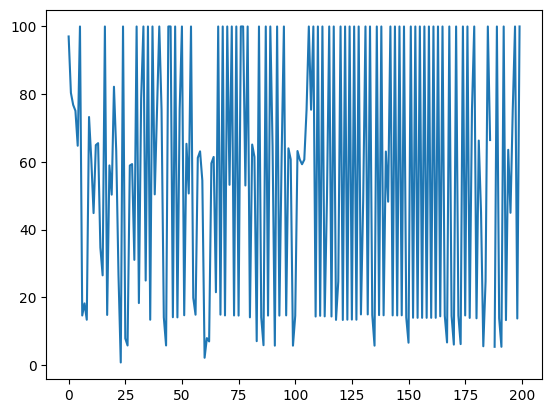

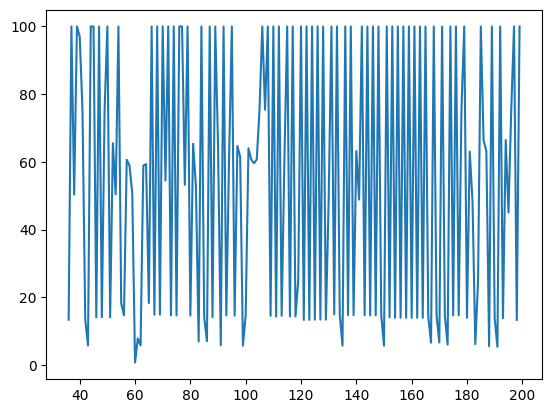

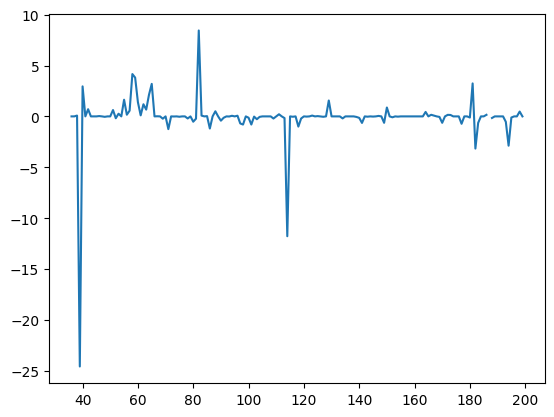

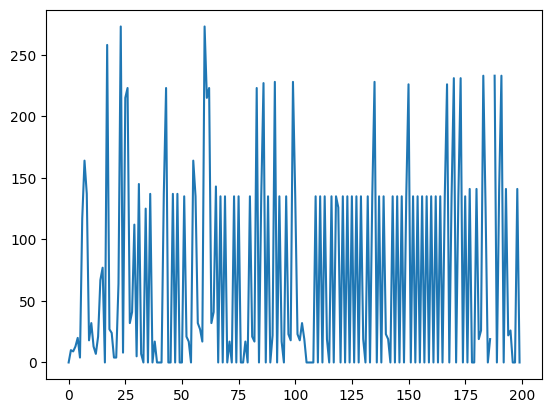

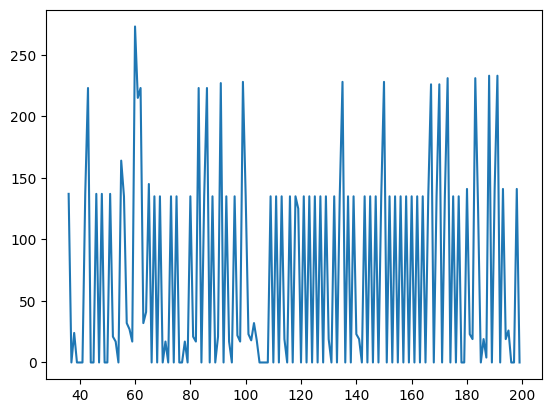

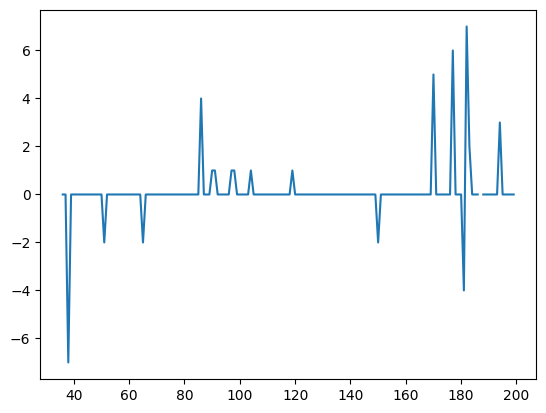

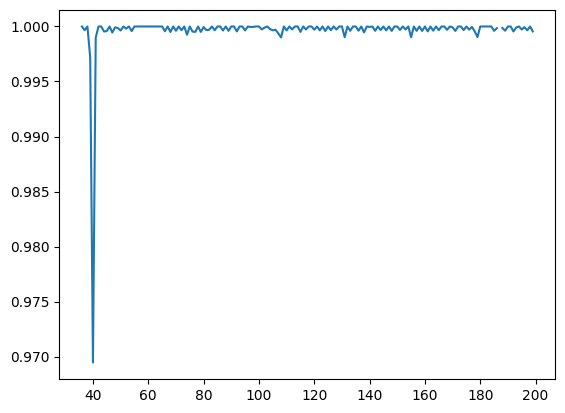

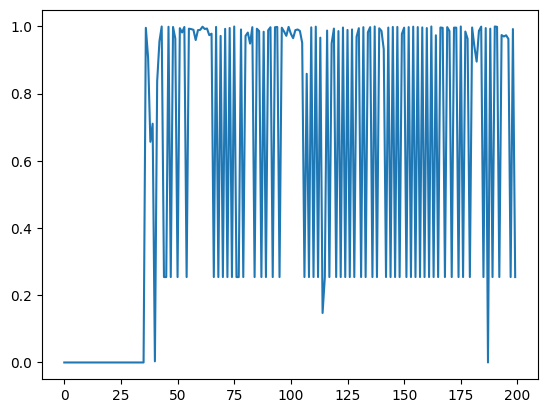

In [4]:
import matplotlib.pyplot as plt

plt.plot(data['MI_After'][:200])
plt.show()
plt.plot(data['MI_Before'][:200])
plt.show()
plt.plot(data['MI_Change'][:200])
plt.show()

plt.plot(data['CC_After'][:200])
plt.show()
plt.plot(data['CC_Before'][:200])
plt.show()
plt.plot(data['CC_Change'][:200])

plt.show()

plt.plot(data['Semantic_Similarity'][:200])
plt.show()
plt.plot(data['Token_Similarity'][:200])
plt.show()

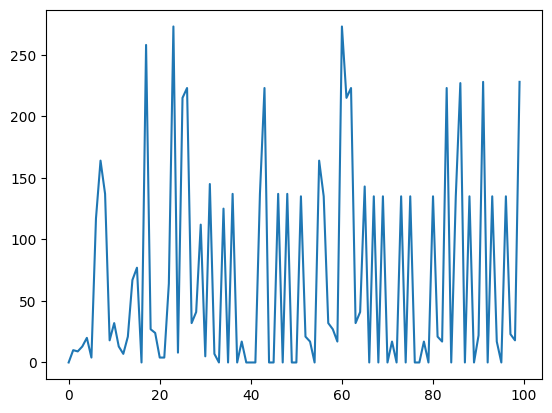

In [9]:
plt.plot(data['CC_After'].iloc[:100])
plt.show()

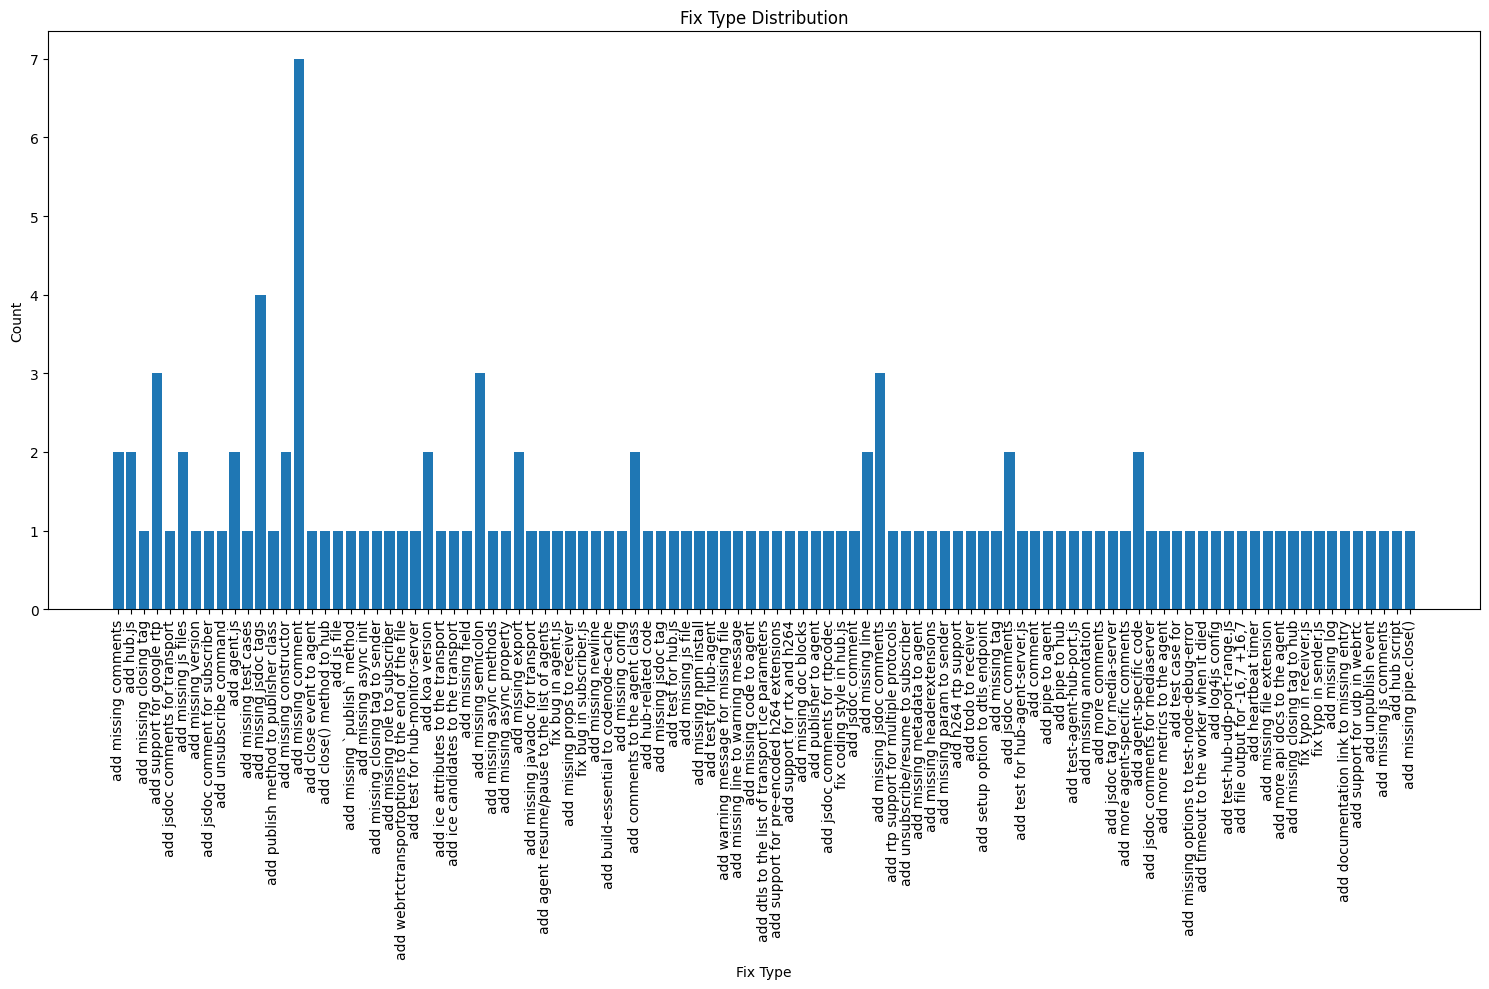

In [15]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load data
with open('repo_stats.json') as f:
    data = json.load(f)

hist_data = data["fix_type_distribution"]  # e.g. {'Bug Fix': 10, 'Feature': 5, ...}

# Plot as bar chart
plt.figure(figsize=(15, 10))
plt.bar(hist_data.keys(), hist_data.values())
plt.xlabel("Fix Type")
plt.ylabel("Count")
plt.title("Fix Type Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
